In [17]:
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import requests
import os
import json
from io import StringIO

In [ ]:
with open('../data/raw/elo_api_name_to_team_map.json', 'r') as f:
    elo_teamname_mapping = json.load(f)

    if not os.path.exists('../data/raw/team_elos/'):
        print(f"create folder ../data/raw/team_elos/")
        os.makedirs('../data/raw/team_elos/')

    for team in list(elo_teamname_mapping.keys()):
        if os.path.exists(f"../data/raw/team_elos/{team}.csv"):
            print(f"Elo {team} alreday downloaded")
            continue
        print(f"Downloading elo for team {team}")
        r = requests.get(f"http://api.clubelo.com/{team}")
        if r.status_code == 200:
            f = open(f"../data/raw/team_elos/{team}.csv", 'w')
            f.write(r.text)
            f.close()
        else:
            print(f"could not find {team}")

## If matches.csv is not existant --> download the data

In [ ]:

if not os.path.exists('../data/raw/matches.csv'):
    print("Downloading match data from https://fbref.com")
    years = list(range(2025, 2019, -1))
    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("user-agent=Mozilla/5.0 ... Chrome/123.0 ...")
    all_matches = []
    standings_url = "https://fbref.com/en/comps/20/Bundesliga-Stats"

    for year in years:
        driver = webdriver.Chrome(options=options)  
        print(f"Year: {year}")
        driver.get(standings_url)
        html = driver.page_source
        time.sleep(8)
        driver.quit()
        soup = BeautifulSoup(StringIO(html))
        standings_table = soup.select('table.stats_table')[0]
        
        links = standings_table.find_all('a')
        links = [l.get('href') for l in links]
        links = [l for l in links if '/squads' in l]
        team_urls = [f"http://fbref.com{l}" for l in links]

        previous_season = soup.select('a.prev')[0].get('href')
        standings_url = f"https://fbref.com{previous_season}"

        for team_url in team_urls:
            team_name = team_url.split('/')[-1].replace('-Stats', '').replace('-', ' ')
            #print(team_name)
            driver = webdriver.Chrome(options=options)
            driver.get(team_url)
            html = driver.page_source
            matches = pd.read_html(StringIO(html), match='Scores & Fixtures')[0]
            soup = BeautifulSoup(html)
            links = soup.find_all('a')
            links = [l.get('href') for l in links]
            links = [l for l in links if l and '/all_comps/shooting' in l]
            driver = webdriver.Chrome(options=options)
            driver.get(f"http://fbref.com{links[0]}")
            html = driver.page_source
            shooting = pd.read_html(StringIO(html), match='Shooting')[0]
            shooting.columns = shooting.columns.droplevel()

            try:
                team_data = matches.merge(shooting[['Date', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt']], on='Date')

            except ValueError:
                continue

            team_data["Season"] = year
            team_data["Team"] = team_name
            all_matches.append(team_data)
            time.sleep(1)
            driver.quit()

            with open('../data/raw/fbref_api_name_to_team_map.json') as f:
                fbref_team_name_mapping = json.load(f)
                match_df = pd.concat(all_matches)
                match_df.columns = [c.lower() for c in match_df.columns]
                match_df['team'] = match_df['team'].apply(lambda x: fbref_team_name_mapping[x])
                match_df.sort_values('date').to_csv('../data/raw/matches.csv', index=False)
else:
    print("matches.csv already exists.")

matches.csv already exists.


In [43]:
import pandas as pd

df = pd.read_csv("../data/raw/matches.csv")

# create match id to make two rows per match to one by merging at a unique match id
df['match_id'] = df.apply(
    lambda row: f"{row['date']}_{'_'.join(sorted([row['team'], row['opponent']]))}",
    axis=1
)
df = df[['date', 'season', 'round', 'day', 'comp', 'match_id', 'time', 'team', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist']]

#set arbitrarily home and away for neutral matches --> we only wnat them to calculate days sonce last match and then kick them
neutrals_df = df[df['venue'] == 'Neutral'].sort_values('match_id')
for i, idx in enumerate(neutrals_df.index):
    new_venue = 'Home' if i % 2 == 0 else 'Away'
    df.loc[idx, 'venue'] = new_venue

# create artifical matches for those where only one exist (if e.g. Bayern played agains Lazio. we only downloaded the data for Bayern)
# But we need a match pair to merge into one big match based dataframe

#get all the matches with just one match
unique_ids = df['match_id'].value_counts()
unique_ids = unique_ids[unique_ids == 1].index
df_single_matches = df[df['match_id'].isin(unique_ids)]
df_copied_matches = df_single_matches.copy()

def switch_home_away(row):
    if row['venue'] == 'Home':
        row['venue'] = 'Away'
    elif row['venue'] == 'Away':
        row['venue'] = 'Home'
    else:
        row['venue'] = 'Neutral'
    row['team'], row['opponent'] = row['opponent'], row['team']
    row['ga'], row['gf'] = row['gf'], row['ga']
    row['xg'], row['xga'] = row['xga'], row['xg']

    row['poss'] = 100.0 - row['poss']

    if row['result'] == 'W':
        row['result'] = 'L'
    elif row['result'] == 'L':
        row['result'] = 'W'
    else:
        row['result'] = 'D'
    return row

# create the matches
df_copied_matches = df_single_matches.apply(switch_home_away, axis=1)

#add the new created matches to our big data frame
df_combined = pd.concat([df, df_copied_matches])

### merge the two cells per match (one per team) to one big match indexed data frame (one row per match)

In [45]:
home_away_cols = ['poss', 'sh', 'sot', 'dist']
home_cols = {col: f"{col}_home" for col in home_away_cols}
away_cols = {col: f"{col}_away" for col in home_away_cols}

df_away = df_combined[df_combined['venue'] == 'Away']
df_home = df_combined[df_combined['venue'] == 'Home']

print(len(df_away))
print(len(df_home))

df_home = df_home.rename(columns={"team": "team_home", 
                                  "opponent": "team_away", 
                                  "gf": "goals_home", 
                                  "ga": "goals_away", 
                                  "xg": "xg_home", 
                                  "xga": "xg_away",
                                  "result": "result_home"})

df_home = df_home.rename(columns=home_cols)
df_away = df_away.rename(columns=away_cols)


columns = list(away_cols.values())
columns.append('match_id')

merged_df = df_home.merge(df_away[columns], on='match_id').drop(columns=['venue'])
merged_df.sort_values('date').to_csv('../data/raw/matches_combined.csv')

2532
2532


### download the elo data for every team and add to the big data frame

In [46]:
from datetime import datetime

elo_api_team_names = ['Leverkusen', 'Werder', 'Stuttgart', 'Holstein', 'UnionBerlin',
 'Bochum', 'Frankfurt', 'Bayern', 'Heidenheim', 'StPauli',
 'Gladbach', 'Hoffenheim', 'Wolfsburg', 'Mainz', 'Dortmund', 'RBLeipzig',
 'Augsburg', 'Freiburg', 'Schalke', 'Bielefeld', 'Hertha', 'Koeln',
 'Darmstadt', 'Fuerth', 'Duesseldorf', 'Paderborn']

#key: df team name, value: elo team name
team_mapping = {
    'Leverkusen': 'Leverkusen',
    'Werder': 'Werder Bremen',
    'Stuttgart': 'Stuttgart',
    'Holstein': 'Holstein Kiel',
    'UnionBerlin': 'Union Berlin',
    'Bochum': 'Bochum',
    'Frankfurt': 'Eint Frankfurt',
    'Bayern': 'Bayern Munich',
    'Heidenheim': 'Heidenheim',
    'StPauli': 'St. Pauli',
    'Gladbach': 'Gladbach',
    'Hoffenheim': 'Hoffenheim',
    'Wolfsburg': 'Wolfsburg',
    'Mainz': 'Mainz 05',
    'Dortmund': 'Dortmund',
    'RBLeipzig': 'RB Leipzig',
    'Augsburg': 'Augsburg',
    'Freiburg': 'Freiburg',
    'Schalke': 'Schalke 04',
    'Bielefeld': 'Arminia',
    'Hertha': 'Hertha BSC',
    'Koeln': 'Köln',
    'Darmstadt': 'Darmstadt 98',
    'Fuerth': 'Greuther Fürth',
    'Duesseldorf': 'Düsseldorf',
    'Paderborn': 'Paderborn 07'
}

elos = {}
for team in elo_api_team_names:
    mapped_name = team_mapping[team]
    elos[mapped_name] = pd.read_csv(f"../data/raw/team_elos/{team}.csv")[['Elo', 'From', 'To']]
    elos[mapped_name]['From'] = pd.to_datetime(elos[mapped_name]['From'], format='%Y-%m-%d')
    elos[mapped_name]['To'] = pd.to_datetime(elos[mapped_name]['To'], format='%Y-%m-%d')
    date_cutoff = datetime.strptime("01/01/2019", "%d/%m/%Y")
    elos[mapped_name] = elos[mapped_name][elos[mapped_name]['From'] > date_cutoff]
    elos[mapped_name] = elos[mapped_name][elos[mapped_name]['To'] > date_cutoff]

def get_elo(date, elo):
    filtered_df = elo.loc[elo['To'] <= date]
    if filtered_df.empty:
        raise ValueError(f"No Elo available before {date} for team.")
    return filtered_df.iloc[-1]['Elo']

def fill_elo_row(row):
    if row['comp'] != 'Bundesliga':
        return pd.Series({'elo_home': float('nan'), 'elo_away': float('nan')})
    date = row['date']
    away_team = row['team_away']
    home_team = row['team_home']
    elo_home = get_elo(date, elos[home_team])
    elo_away = get_elo(date, elos[away_team])
    return pd.Series({'elo_home': elo_home, 'elo_away': elo_away})

merged_df[['elo_home', 'elo_away']] = merged_df.apply(fill_elo_row, axis=1)
merged_df.drop(columns='match_id').sort_values('date').reset_index(drop=True).to_csv('../data/raw/matches_combined.csv')

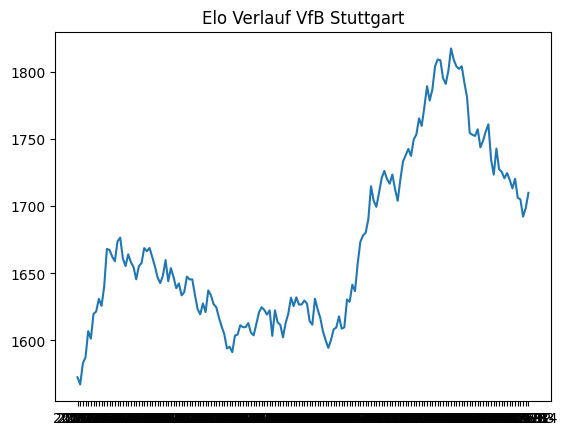

In [ ]:
import matplotlib.pyplot as plt

teams = ['Stuttgart', 'Dortmund']

for team in teams:
    stuttgart = merged_df[((merged_df['team_away'] ==  team) | (merged_df['team_home'] == team)) & (merged_df['comp'] == 'Bundesliga')]

    elo_vfb = {}

    for index, row in stuttgart.iterrows():
        if row['team_home'] == 'Stuttgart':
            elo_vfb[f"{row['season']}-{row['round'].split(' ')[-1]}"] = row['elo_home']
        else:
            elo_vfb[f"{row['season']}-{row['round'].split(' ')[-1]}"] = row['elo_away']


    plt.plot(elo_vfb.keys(), elo_vfb.values())
plt.title('Elo Verlauf VfB Stuttgart')
plt.show()